# Transformer Math

* Understand accelerator capabilities
* Determine if our environment is compute or memory bound
* Increase batch size, if needed 
* Calculate text-generation latency, total time, and total cost

_This notebook is derived from this awesome blog post:  https://www.baseten.co/blog/llm-transformer-inference-guide/_

## Data types

| Data type | Memory (bytes) |
|-----|----|
| FP32 | 4 |
| TF32 Tensor Core | 4 |
| BFLOAT16 Tensor Core | 2 |
| FP16 Tensor Core | 2 |
| FP8 Tensor Core | 1 |
| INT8 Tensor Core | 1 |
| INT4 Tensor Core | 0.5 |


### Accelerator: Nvidia A10 GPU
AWS g5 series: https://aws.amazon.com/ec2/instance-types/g5/

Specifically, we choose a g5.2xlarge for this analysis.

* **GPU Memory**: 24 GB GDDR6
* **GPU Memory Bandwidth**: 600 GBits/s
* **Compute bandwidth per data type**:

| Data type | Compute bandwidth |
|-----|----|
| FP32 | 31.2 TFlops |
| TF32 | 62.5 TFlops |
| BFLOAT16 | 125 TFlops |
| FP16 | 125 TFlops |
| FP8 | Not supported* |
| INT8 | 250 TOps |
| INT4 | 500 TOps |

_*FP8 is not supported by Nvidia A10 GPU._

In [2]:
# Nvidia A10 GPU
total_accelerator_memory = 24 # GBs
compute_bw = 125 # TFlops
memory_bw = 600 # GB/s

# Nvidia A100 GPU (80GB)
# total_accelerator_memory = 80 # GBs
# compute_bw = 312 # TFlops (~2.5x A10)
# memory_bw = 2039 # GB/s (~16x A10)

### Analyze: Llama2-7B @ 16-bit precision

* **Model**: Llama2-7B
* **Number of parameters**: 7 billion
* **Data types**:

| Data type | GPU Memory (GB) |
|-----|----|
| FP32 | 28* |
| TF32  | 28 |
| BFLOAT16  | 14 |
| FP16 | 14 |
| FP8 | 7 |
| INT8 | 7 |
| INT4 | 3.5** |

_*7 billion parameters * 2 byte per parameter = 28 GB_

_**7 billion parameters * 0.5 bytes per parameter = 3.5 GB_

### Calculate memory needed to load model

In [3]:
num_params = 7_000_000_000
bits_per_param = 16 # 16-bits per param (BFLOAT16, FP16)

```
required_model_memory = \
  num_params * bits_per_param \
  / 8 / 1_000_000_000 # 8 bits per byte, 1,000,000,000 bytes per GB 
```

In [4]:
required_model_memory = \
  num_params * bits_per_param \
  / 8 / 1_000_000_000 # 8 bits per byte, 1,000,000,000 bytes per GB 
    
required_model_memory

14.0

### Enough accelerator memory to load the model?
```
excess_memory = 
  total_accelerator_memory 
  - required_model_memory
```

In [5]:
excess_memory = total_accelerator_memory - required_model_memory

excess_memory

10.0

In [6]:
if (excess_memory > 0):
    print(f"Enough memory to load the model into the accelerator at {bits_per_param} bit precision.")
else:
    print(f"Not enough memory to load the model into the accelerator at {bits_per_param} bit precision.")

Enough memory to load the model into the accelerator at 16 bit precision.


# Memory or compute bound?

To determine if our workload is memory or compute bound, let's calculate the number of operations that our accelerator can perform while a single byte of memory is moved in (loaded) or out (stored) of the accelerator. This is called the `flops::byte` ratio.

```
flops_to_byte_ratio
  = compute_bw           # teraflops per second
    / memory_bw          # GBs per second
    * 1_000_000_000_000  # flops per teraflop
    / 1_000_000_000      # bytes per GB
```

In [28]:
flops_to_byte_ratio \
  = compute_bw \
    / memory_bw \
    * 1_000_000_000_000 \
    / 1_000_000_000 

flops_to_byte_ratio  # ~208 flops per second for each byte moved

208.33333333333334

### Compare to the `arithmetic intensity` of the model

Next, let's calculate the `arithmetic intensity` of the model and compare it to the `flops::byte` ratio for the hardware. 

Arithmetic intensity is hardware-agnostic and represents the number of operations a model requires divided by the number of bytes needed (loaded or stored).

As a reminder, bytes are moved in and out of memory to perform calculations on the accelerator and store the results back to memory.

For Transformer-based generative AI models, the Transformers' attention layers are the most resource-intensive, so we will focus our attention on the attention layers!

### Analyze memory movement in the attention heads

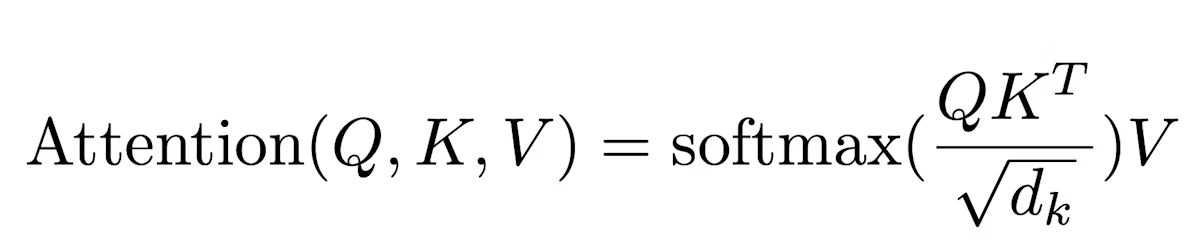

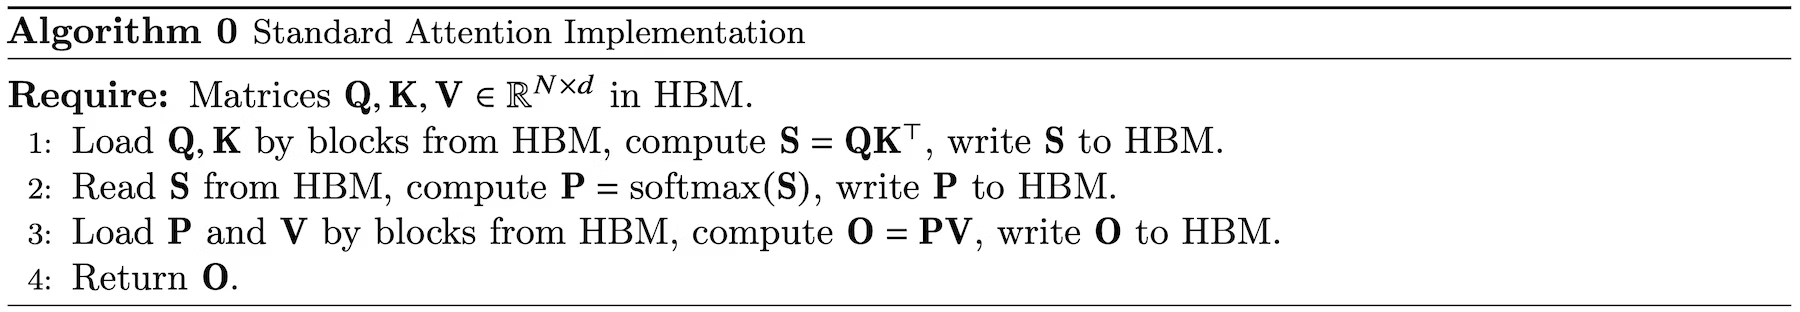

|Line in algo|Load from memory|Compute|Store to memory|
|----|----|----|----|
|Line 1:|	size_fp16 * (size_Q + size_K)|	cost_dot_product_QK * size_S|	size_fp16 * size_S|
||2 * 2 * (N * d_head)|	(2 * d_head) * (N * N)| 2 * (N * N)|
|Line 2:|	size_fp16 * size_S|	cost_softmax * size_P|	size_fp16 * size_P|
||2 * (N * N)|	3 * (N * N)|	2 * (N * N)|
|Line 3:|	size_fp16 * (size_P + size_V)|	cost_dot_product_PV * size_O|	size_fp16 * size_O|
||2 * ((N*N) + (N * d_head))|	(2 * N) * (N * d_head)|	2 * (N * d_head)|

In [14]:
# memory-load bytes from the table above
load_memory_movement_bytes \
  = (2 * 2 * (N * d_head)) \
    + (2 * (N * N)) \
    + (2 * ((N * N) + (N * d_head)))

# memory-store bytes from the table above
store_memory_movement_bytes \
  = (2 * (N * N)) \
    + (2 * (N * N)) \
    + (2 * (N * d_head))

# total memory movement in bytes
total_memory_movement_bytes \
  = load_memory_movement_bytes \
    + store_memory_movement_bytes 

total_memory_movement_bytes

138412032

In [15]:
total_compute_flops \
  = (2 * d_head) * (N * N) \
    + (3 * (N * N)) \
    + (2 * N) * (N * d_head)

total_compute_flops

8640266240

```
arithmetic_intensity 
  = total_compute_flops 
    / total_memory_movement_bytes 
```

In [16]:
arithmetic_intensity \
  = total_compute_flops \
    / total_memory_movement_bytes  

arithmetic_intensity # required number of flops per byte of movement

62.42424242424242

### Compare model and accelerator capabilities
* **Compute bound**: The model requires more than the `flops::byte` ratio offered by the accelerator

* **Memory bound**: The model requires less than the `flops::byte` ratio offered by the accelerator

_More info here: https://docs.nvidia.com/deeplearning/performance/dl-performance-gpu-background/index.html#understand-perf_


In [79]:
if (arithmetic_intensity > flops_to_byte_ratio):
    print("This model is compute bound on this accelerator.")
elif (arithmetic_intensity < flops_to_byte_ratio):
    print("This model is memory bound on this accelerator.")
else:
    print("This model requires exactly the flops::byte ratio of this accelerator.")  # very unlikely

This model is memory bound on this accelerator.


Memory bound means that the accelerator is under-utilized relative to the needs of the model.

What if we moved more bytes per second?  This would increase the number of flops and, subsequently, the accelerator's utilization during each second.  Let's explore how to move more bytes of data in the same amount of time.

# Prompt batching
To improve the accelerator's utilization, let's batch a set of prompts together into a single request.

To determine the batch size (number of tokens), we need to analyze the following:
* 1. the amount of excess memory available on the accelerator
* 2. the amount of KV cache memory needed per token

### Excess memory available on the accelerator
After loading the model, we can determine how much RAM is available on the accelerator.

In [7]:
print(f"We have {excess_memory} GB remaining on our accelerator.") # GB

We have 10.0 GB remaining on our accelerator.


### KV cache memory needed per token
Each prompt occupies additional memory in the KV cache, so let's calculate the amount of additional bytes are stored in the KV cache per token. Given this value, we can calculate roughly how many additional tokens can fit into the accelerator's `excess_memory`.

### Model-specific values
* `N`:  Max number of tokens (context window) processed by the model.
* `d_head`:  Dimension of a single attention head (number of params).

For Llama 2 7B, `d_head = 128`.

* `n_heads`:  number of attention heads.

For Llama 2 7B, `n_heads = 32`.

* `n_layers`: number of attention blocks.

For Llama 2 7B, `n_layers = 32`.

`d_heads` is the dimension of all heads. (`d_heads` = `d_head` * `n_heads`)

For Llama 2 7B, d_heads = 4096.

In [31]:
# For Llama2 7B
N = 4096 # number of tokens
d_head = 128 # dimension of single attention head
n_heads = 32
n_layers = 32
d_heads = d_head * n_heads

d_heads

4096

At half precision (BFLOAT16/FP16), each value in the KV cache requires 2 bytes. 

To calculate the number of values stored in the KV cache size, we multiply `n_layers` x `d_heads` x 2 (1 for K and 1 for V).  We then multiply the result x bits_per_param x 8 bytes per paramand divide by 1,000,000,000 to get the number of GB required per token. 

```
kv_cache_gigabytes_per_token \
  = n_layers * d_heads \
    * 2 \                   # 1 for key + 1 for value
    * bits_per_param \      # precision in bits per parameter
    / 8 \                   # bits per byte   
    / 1_000_000_000         # convert to GB
```

In [32]:
kv_cache_gigabytes_per_token \
  = n_layers * d_heads \
    * 2 \
    * bits_per_param \
    / 8 \
    / 1_000_000_000 

kv_cache_gigabytes_per_token # GB/token

0.000524288

Now let's  divide the amount of available memory in our accelerator (`excess_memory`) by the memory required per token (`kv_cache_gigabytes_per_token`) to determine the number of additional tokens that can fill our prompt batch.

```
kv_cache_available_batch_tokens \
  = excess_memory / kv_cache_gigabytes_per_token
```

In [10]:
kv_cache_available_batch_tokens \
  = excess_memory / kv_cache_gigabytes_per_token

kv_cache_available_batch_tokens

19073.486328125

This KV cache can accommodate ~19,000 tokens. Given Llama 2 7B's max number of context-window tokens (`N=4096`), we can calculate the batch size.

```
import math

batch_size = \
  math.floor(  # drop the decimal
    kv_cache_available_batch_tokens \ # available tokens 
    / N  # context-window size
  ) 
```

In [27]:
import math

batch_size = \
  math.floor(
    kv_cache_available_batch_tokens \
    / N) 

batch_size # available number of tokens divided by context-window size

4

In [143]:
print(f"This model and accelerator can support a batch size of {batch_size} prompts per request.")

This model and accelerator can support a batch size of 4 prompts per request.


# Prefill optimization

In practice, the flow through the Transformer is actually split across 2 phases:  prefill and token-generation.

1. **Prefill**: The model calculates the attention for all tokens in a given set of input prompts. It then stores the results in GPU RAM using a key-value (KV) cache. This KV cache is used during the next phase, token generation.

2. **Token generation**: The model uses the results of the prefill phase (KV cache) to generate new tokens using autoregressive sampling.

Interestingly, the prefill phase is typically compute bound while token-generation phase is memory bound.

While this makes our analysis a bit more complicated, remember that we already determined our overall system is memory-bound based on the model's arithmetic intensity and the accelerator's flops::byte ratio.

Considering the prefill phase is compute-bound, let's analyze how this phase affects our overall latency and time to generate a response for our batch of input prompts.

# Prefill time

It's often useful to estimate the amount of time spent in the prefill phase as this affects the overall time of generating responses to our batch of prompt inputs.

Since the prefill stage is compute-bound, we will use the compute bandwidth for the accelerator to calculate the `prefill_time` along with a given `num_tokens` for our entire batch.

```
prefill_time \
  = num_tokens \       # number of tokens in our batch
    * num_params \     # number of params
    * bits_per_param \ # bits per param
    / 8 \              # bits per byte
    / compute_bw       # teraflops (compute bound)
    / 1_000_000_000    # flops per teraflop
```

In [113]:
num_tokens = 350 # total number of tokens for our batch

In [114]:
compute_bw # TFlops

125

In [115]:
prefill_time \
  = num_tokens \
    * num_params \
    * bits_per_param \
    / 8 \
    / compute_bw \
    / 1_000_000_000

prefill_time # time (ms) to populate the KV cache in the prefill stage

39.2

# Time per Output Token (TPOT)
It's often useful to estimate the time per output token (TPOT).  Since the token-generation phase is memory bound, we will use memory bandwidth in our calculation.  Additionally, let's expand beyond the attention layers and consider all model parameters in our calculation.

_Note: This is an approximation that assumes there is no communication overhead - as well as perfect parallelization during the computations._
    
```
time_per_output_token \ 
  = num_params \        # model weights
    * bits_per_param    # bits per param
    / 8 \               # bits per byte
    / memory_bw \       # memory bandwidth (memory-bound)
    / 1_000_000         # 1,000,000 milliseconds per second
```

In [116]:
time_per_output_token \
  = num_params \
    * bits_per_param \
    / 8 \
    / memory_bw \
    / 1_000_000

time_per_output_token # time (ms) per output token (TPOT)

23.333333333333332

# Total Time to Generate All Tokens
While this measurement does not have a fancy acronym, it's useful to estimate the total time to generate all tokens.

In this calculation, we introduce the `num_output_tokens` which, in some scenarios like document-summarization, is less than the number of input tokens (`num_tokens`).

```
total_generation_time \
  = prefill_time \          # prefill time
    + num_output_tokens \   # number of output tokens
    * time_per_output_token \ # TPOT
    / 1_000                 # milliseconds per second
```

In [126]:
num_output_tokens = 150  # total output tokens for batch of input prompts

In [127]:
total_generation_time \
  = prefill_time \
    + num_output_tokens \
    * time_per_output_token \

total_generation_time # time (ms) to generate all output tokens

3539.2

# Total cost for text generation
Let's estimate the cost to generate tokens for our batch of input prompts.

More pricing info here:  https://aws.amazon.com/ec2/instance-types

In [135]:
# g5.2xlarge
instance_cost_per_hour = 1.21  # USD per hour

In [138]:
cost_for_total_generation \
  = total_generation_time \
    * instance_cost_per_hour \
    / 3.6e6 # milliseconds per hour

cost_for_total_generation  # USD for text generation

0.0011895644444444443

# Time to First Token (TTFT)
It's often useful to estimate the time to first (generated) token (TTFT) as this represents the perceived response time of the overall system (e.g. chatbot).  

Remember that the prefill phase introduces an initial latency to populate the KV cache before any tokens are generated.

This latency is estimated by adding the `prefill_time` to the `time_per_output_token`.

```
time_to_first_token \
  = prefill_time \
    + time_per_output_token
```

In [139]:
time_to_first_token \
  = prefill_time \
    + time_per_output_token

time_to_first_token # time (ms) to first token (TTFT)

62.53333333333333

# Example log line from HuggingFace inference server
In practice, there are additional stages including input validation and queuing as demonstrated in this example log line from HuggingFace's Text Generation Inference (TGI) server:

```
total_time="8.469818244s" validation_time="1.65261ms" queue_time="30.91µs" inference_time="8.468134904s" time_per_token="16.539325ms"
```

In this case, the calculation for TTFT is as follows:

```
time_to_first_token \
  = validation_time 
    + queue_time 
    + time_per_token # time per output token (TPOT)
```

# TODO: Continuous batching

https://www.anyscale.com/blog/continuous-batching-llm-inference

# TODO:  Throughput, MBU, and MFU

https://www.databricks.com/blog/llm-inference-performance-engineering-best-practices

The solid sloped line of the orange-shaded region shows the maximum possible throughput if memory bandwidth is fully saturated at 100%. 

However, in reality for low batch sizes (white dot), the observed performance is lower than maximum – how much lower is a measure of the MBU. 

For large batch sizes (yellow region), the system is compute bound, and the achieved throughput as a fraction of the peak possible throughput is measured as the Model Flops Utilization (MFU).

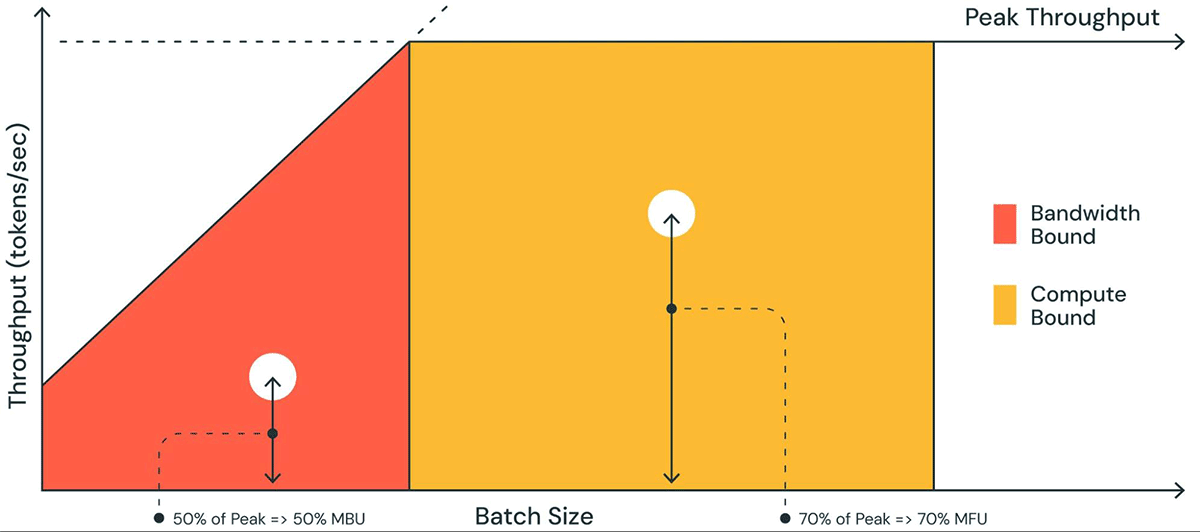

# TODO: Flash Attention

https://developer.nvidia.com/blog/mastering-llm-techniques-inference-optimization/

# TODO: NVIDIA TensorRT-LLM

https://medium.com/@plienhar/llm-inference-series-5-dissecting-model-performance-6144aa93168f

# TODO:  PEFT/LoRAX?

# TODO:  Inference Optimizations

https://developer.nvidia.com/blog/mastering-llm-techniques-inference-optimization/

Prefill:  compute-bound because extent of input data is known upfront so the matrices can be combined into large matrix-matrix multiplications on the highly parallelized GPU.

Decoding/text-generation:  Output is sampled at inference time so the matrices are smaller, and difficult to combine/parallelize.  

...The speed at which the data (weights, keys, values, activations) is transferred to the GPU from memory dominates the latency, not how fast the computation actually happens. In other words, this is a memory-bound operation...

